In [1]:
import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics
from pipeline.python.coregistration import align_fov as coreg

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 65

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/paradigm/tifs_to_data_arrays.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", lin

In [5]:
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import train_test_split
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

import seaborn as sns
from pipeline.python import utils as utils # import rf_utils as rfutils


In [3]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [4]:
%matplotlib inline

## Some aggregate plotting stuff

In [6]:
visual_areas, area_colors = utils.set_threecolor_palette()
dpi = utils.set_plot_params()

# Select dataset

In [7]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'

# Set output dirs

In [8]:
aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Example FOV -------------------------------------------------------------------------------

In [9]:
#animalid = 'JC113' #'JC091' #'JC097' #'JC085'
#session = '20191017' # '20190614' #'20190617' #'20190626'

animalid = 'JC080'
session = '20190603'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run1'


# Load data

# Select colormap

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'azimuth_pos_nic_Edge_LEGEND_abs')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'elevation_pos_nic_Edge_LEGEND_abs')


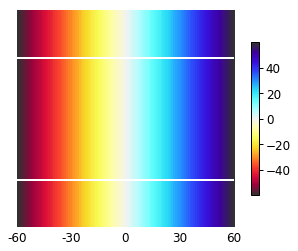

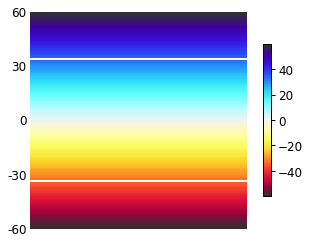

In [28]:
# # Load colormap
cmap_name = 'nic_Edge'
# zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=True, 
                                                   return_cmap=True)

In [11]:
# Load data metainfo
# run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
# RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
# analysis_dir = RETID['DST']
# retinoid = RETID['analysis_id']
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) 
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
run_dir = RETID['DST'].split('/retino_analysis/')[0]
curr_dst_dir = os.path.join(run_dir, 'retino_analysis', 'retino_structure')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print("Saving output to:\n %s" % curr_dst_dir)

FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC080_20190603_FOV1_zoom2p0x_retino_run1_analysis001
Saving output to:
 /n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure


In [12]:
magratio, phase, trials_by_cond = ret_utils.fft_results_by_trial(RETID)

d2 = scaninfo['pixels_per_line']
d1 = scaninfo['lines_per_frame']
print(d1, d2)

# Get ROIID and projection image
#masks_soma, masks_np, zimg = ret_utils.load_soma_and_np_masks(RETID)
#roiid = RETID['PARAMS']['roi_id']
ds_factor = int(RETID['PARAMS']['downsample_factor'])
#nrois_total, d1, d2 = masks_soma.shape
print(ds_factor)

TRIALS BY COND:
{u'top': [14, 3, 2, 4], u'right': [13, 12, 6, 9], u'left': [11, 15, 16, 1], u'bottom': [10, 5, 7, 8]}
('Trials:', [11, 10, 13, 12, 15, 14, 16, 1, 3, 2, 5, 4, 7, 6, 9, 8])
(512, 512)
2


('got phase:', 2.333320291647567e-06, 6.283115437779566)
('got absolute:', -2.914841967655934, 2.6483577684598147)
('Delay:', 0.16502800130234574, 5.7480050588169584)


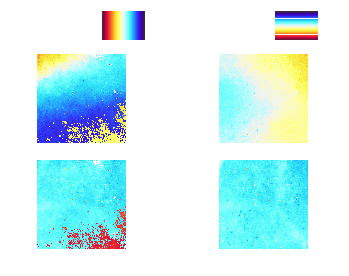

In [29]:
pix_mag_thr=0.002

abs_vmin, abs_vmax = (-np.pi, np.pi)
absolute_az, absolute_el, delay_az, delay_el = ret_utils.absolute_maps_from_conds(magratio, phase, trials_by_cond,
                                                                                 mag_thr=pix_mag_thr, dims=(d1, d2),
                                                                                 plot_conditions=False, ds_factor=ds_factor)

shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, 
                                          oldmin=0, oldmax=2*np.pi)
shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, 
                                          oldmin=0, oldmax=2*np.pi)

fig = ret_utils.plot_phase_and_delay_maps(absolute_az, absolute_el, 
                                          shift_az_delay, shift_el_delay,
                                         cmap=cmap_phase, vmin=abs_vmin, vmax=abs_vmax)


#### Shift maps to match

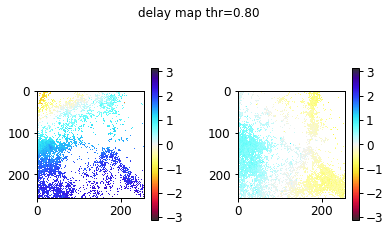

In [36]:
delay_map_thr=0.8

#shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)
#shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)

filt_az = np.where(abs(shift_az_delay)<delay_map_thr, absolute_az, np.nan)
filt_el = np.where(abs(shift_el_delay)<delay_map_thr, absolute_el, np.nan)

fig, axn = pl.subplots(1,2)
im0 = axn[0].imshow(filt_az, cmap=cmap_phase, vmin=-np.pi, vmax=np.pi)
pl.colorbar(im0, ax=axn[0], shrink=0.7, orientation='vertical')
im1 = axn[1].imshow(filt_el, cmap=cmap_phase, vmin=-np.pi, vmax=np.pi)
pl.colorbar(im1, ax=axn[1], shrink=0.7, orientation='vertical')

pl.suptitle("delay map thr=%.2f" % delay_map_thr)
pl.subplots_adjust(wspace=0.5)

#### Smooth

In [37]:
# desired_radius_um = 10.0 #20.0
# pixel_size = putils.get_pixel_size()
# um_per_pixel = np.mean(pixel_size) / ds_factor # divide by DS factor (pixels are half if ds=2)
# pixels2dilate = desired_radius_um/um_per_pixel
# print("Measured pixel size: %s (~%.2fum/pix).\nPixel size with ds_factor %.2f = %i" % (str(pixel_size), um_per_pixel, ds_factor, pixels2dilate))

pixel_size = putils.get_pixel_size()
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)


In [1542]:
# #a = cv2.getGaussianKernel(ksize=(5,5), sigma=1)
# xdir_gauss = cv2.getGaussianKernel(7, 7)
# kernel = np.multiply(xdir_gauss.T, xdir_gauss)
# print("Kernel: \n", kernel)
    
# pl.figure()
# pl.imshow(kernel)

In [50]:
from pipeline.python.classifications import gradient_estimation as grd
import math

In [42]:
# Spatial smooth neuropil dilated masks 
nan_smooth=2
smooth_fwhm=3
use_phase_smooth=False

if use_phase_smooth:
    azim_smoothed = ret_utils.smooth_phase_nans(filt_az, smooth_fwhm,smooth_fwhm)
    elev_smoothed = ret_utils.smooth_phase_nans(filt_el, smooth_fwhm, smooth_fwhm)
else:
    azim_smoothed = ret_utils.smooth_neuropil(filt_az, smooth_fwhm=smooth_fwhm)
    elev_smoothed = ret_utils.smooth_neuropil(filt_el, smooth_fwhm=smooth_fwhm)

# azim_fillnan = fill_and_smooth_nans(azim_smoothed, kx=nan_smooth, ky=nan_smooth)
# elev_fillnan = fill_and_smooth_nans(elev_smoothed, kx=nan_smooth, ky=nan_smooth)
azim_fillnan = grd.fill_and_smooth_nans_missing(azim_smoothed, kx=nan_smooth, ky=nan_smooth)
elev_fillnan = grd.fill_and_smooth_nans_missing(elev_smoothed, kx=nan_smooth, ky=nan_smooth)


# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_fillnan, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_fillnan, pixel_size, normalize=False)
print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())
print(elev_r[~np.isnan(elev_r)].min(), elev_r[~np.isnan(elev_r)].max())

az_fill = azim_r.copy()
el_fill = elev_r.copy()

vmin, vmax = (-np.pi, np.pi)

(-1.6593249411472824, 2.482602537499566)
(-0.9295814596805142, 0.7155893645701473)


(u'/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure', 'pixelmaps_smooth-3_magthr-0.002_delaymapthr-0.80')


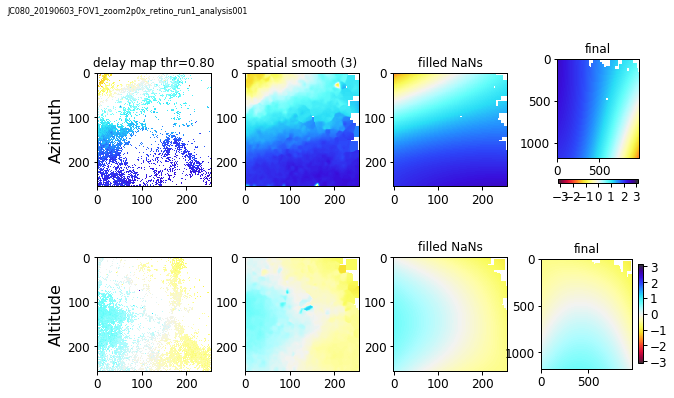

In [45]:
fig, axn = pl.subplots(2,4, figsize=(10,6))

ax = axn[0,0]
ax.imshow(filt_az, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_ylabel('Azimuth')
ax.set_title('delay map thr=%.2f' % delay_map_thr)

ax = axn[0, 1]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 2]
im0 = ax.imshow(azim_fillnan, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')

ax = axn[0, 3]
im0 = ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('final')
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)

ax = axn[1, 0]
ax.imshow(filt_el, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
im1= ax.imshow(elev_fillnan, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')

ax = axn[1, 3]
im1= ax.imshow(el_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('final')
pl.colorbar(im1, ax=ax, orientation='vertical', shrink=0.7)


pl.subplots_adjust(wspace=0.3, hspace=0.3)
putils.label_figure(fig, data_id)
figname = 'pixelmaps_smooth-%i_magthr-%.3f_delaymapthr-%.2f' % (smooth_fwhm, pix_mag_thr, delay_map_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

# Do it all in one go

In [1502]:
# animalid = 'JC091' #'JC091' #'JC097' #'JC085'
# session = '20191008' # '20190614' #'20190617' #'20190626'

# #animalid = 'JC090'
# #session = '20190605'
# fov = 'FOV1_zoom2p0x'
# retinorun = 'retino_run1'

In [1503]:
# delay_map_thr =.5
# pix_mag_thr = 0.003
# smooth_fwhm = 7
# cmap_name = 'nic_Edge'

# az_fill, el_fill, params, RETID = grd.pixel_gradients(animalid, session, fov, 
#                                                       retinorun='retino_run1', 
#                 traceid=traceid, mag_thr=pix_mag_thr, delay_map_thr=delay_map_thr, 
#                 cmap=cmap_name, smooth_fwhm=smooth_fwhm) 


# Convert to screen units

In [46]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [47]:
plot_degrees = True

vmin=-np.pi
vmax=np.pi
img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, 
                       newmin=screen_min, newmax=screen_max)
img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax,
                       newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)

# Calculate gradients
# if plot_degrees:
#     grad_az = calculate_gradients(img_az)
#     grad_el = calculate_gradients(img_el)
#     vmin, vmax = (screen_min, screen_max)
# else:
#     grad_az = calculate_gradients(az_fill)
#     grad_el = calculate_gradients(el_fill)
#     # vmin, vmax = (-np.pi, np.pi)
    
print(vmin, vmax)

spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''


(-59.7782, 59.7782)


# Identify borders


In [53]:
import skimage
from skimage.color import label2rgb
from skimage.measure import label, regionprops, find_contours
import time

In [73]:
h_map = img_el.copy()
v_map = img_az.copy()

# Calculate gradients
# ---------------------------------------------------------
[h_gy, h_gx] = np.array(grd.gradient_phase(h_map))
[v_gy, v_gx] = np.array(grd.gradient_phase(v_map))

h_gdir = np.arctan2(h_gy, h_gx) # gradient direction
v_gdir = np.arctan2(v_gy, v_gx)

# Create sign map
# ---------------------------------------------------------
gdiff = v_gdir-h_gdir
gdiff = (gdiff + math.pi) % (2*math.pi) - math.pi

#O=-1*np.sin(gdiff)
O=np.sin(gdiff) # LEFT goes w/ BOTTOM.  RIGHT goes w/ TOP.
S=np.sign(O) # Discretize into patches

# Calculate STD, and threshold to separate areas (simple morph. step)
# ---------------------------------------------------------
std_thr = .5

O_sigma = np.nanstd(O)
S_thr = np.zeros(np.shape(O))
S_thr[O>(O_sigma*std_thr)] = 1
S_thr[O<(-1*O_sigma*std_thr)] = -1

# Create segmented + labeled map
# ---------------------------------------------------------
filled_smap = grd.fill_nans(S_thr)
labeled_image, n_labels = skimage.measure.label(
                             filled_smap, background=0, return_num=True)

image_label_overlay = label2rgb(labeled_image) #, image=segmented_img) 
props = regionprops(labeled_image, filled_smap)
region_labels = [region.label for region in props]
print(region_labels)

[1, 2, 3, 4, 5]


#### Test w/ morphological steps


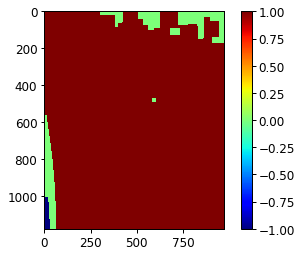

In [65]:
nozeros = S.copy()

k1 = 5
niter = 5
kernel =  np.ones((k1, k1))
closing_s1 = cv2.morphologyEx(S, cv2.MORPH_CLOSE, kernel, iterations=niter)

k2 = 5
niter=5
kernel = np.ones((k2, k2))
opening_1 = cv2.morphologyEx(closing_s1, cv2.MORPH_OPEN, kernel, iterations=niter)

k3 = 5 #5
niter = 5
kernel = np.ones((k3, k3))
#dilation = cv2.dilate(opening_1, kernel, iterations=niter)
dilation = cv2.morphologyEx(opening_1, cv2.MORPH_CLOSE, kernel, iterations=niter)

#nozeros[S==0] = np.nan
test_sm = grd.fill_nans(dilation)
pl.figure()
pl.imshow(test_sm, cmap='jet')
pl.colorbar()

#### Plot steps

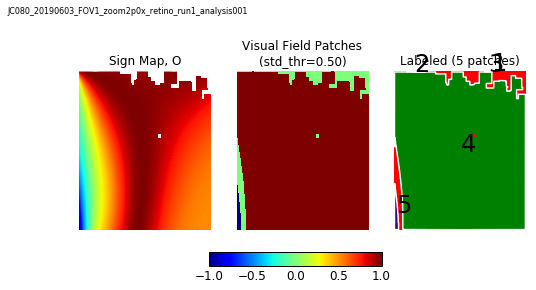

In [76]:
# Plot steps

fig, axn = pl.subplots(1,3, figsize=(8,4))

axn[0].set_title('Sign Map, O')
im0 = axn[0].imshow(O, cmap='jet'); axn[0].axis('off');

axn[1].set_title('Visual Field Patches\n(std_thr=%.2f)' % std_thr)
im = axn[1].imshow(S_thr, cmap='jet'); axn[1].axis('off');

cbar_ax = fig.add_axes([0.35, 0.1, 0.3, 0.05])
cbar_ticks = np.linspace(-1, 1, 5)
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=cbar_ticks)
cbar_ax.tick_params(size=0)

ax = axn[2]
ax.imshow(image_label_overlay)
for ri, region in enumerate(props): 
    ax.text(region.centroid[1], region.centroid[0], 
            '%i' % region.label, fontsize=24, color='k')
for index in range(1, labeled_image.max()):
    label = props[index].label
    contour = find_contours(labeled_image == label, 0.5)[0]
    ax.plot(contour[:, 1], contour[:, 0], 'w')
ax.set_title('Labeled (%i patches)' % len(region_labels))
ax.axis('off')

label_figure(fig, data_id)
    

In [80]:
labeled_image.shape

(1177, 972)

# Select area of interest and do the stuff

(-0.5, 971.5, 1176.5, -0.5)

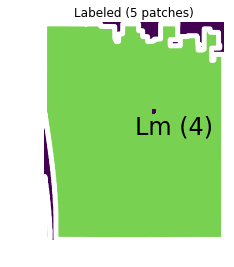

In [85]:
region_dict={4: 'Lm'}

fig, ax = pl.subplots()
ax.imshow(labeled_image)
for ri, region in enumerate(props):
    if region.label in region_dict.keys():
        region_name = region_dict[region.label]
        ax.text(region.centroid[1], region.centroid[0], 
                '%s (%i)' % (region_name, region.label), fontsize=24, color='k')
    contour = find_contours(labeled_image == region.label, 0.5)[0]
    ax.plot(contour[:, 1], contour[:, 0], 'w', lw=5)
    
ax.set_title('Labeled (%i patches)' % len(region_labels))
ax.axis('off')

# Calculate gradient for segmented areas

In [93]:
def overlay_contours(props, labeled_image, ax=None, lc='w', lw=2):
    if ax is None:
        fig, ax = pl.subplots()
        
    for index in range(1, labeled_image.max()):
        label = props[index].label
        contour = find_contours(labeled_image == label, 0.5)[0]
        ax.plot(contour[:, 1], contour[:, 0], lc, lw=lw)
    return ax

In [86]:
segemented_areas={}
for prop in props:
    if prop.label in region_dict.keys():
        region_id = prop.label
        region_name = region_dict[region_id]

        region_mask = np.copy(labeled_image.astype('float'))
        region_mask[labeled_image != region_id] = 0
        region_mask[labeled_image == region_id] = 1

        segemented_areas[region_id] = {'id': region_id, 'name': region_name, 'mask': region_mask}

In [87]:
segemented_areas

{4: {'id': 4, 'mask': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]), 'name': 'Lm'}}

In [89]:
msk_ = segemented_areas[4]['mask']
# curr_msk = np.logical_not(msk_)

thr_img_az = img_az.copy()
thr_img_az[msk_==0] = np.nan
grad_az = grd.calculate_gradients(thr_img_az)

thr_img_el = img_el.copy()
thr_img_el[msk_==0] = np.nan
grad_el = grd.calculate_gradients(thr_img_el)


#### Unit vector

In [90]:
avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL]avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ]avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

print(vhat_az, vhat_el)


[EL]avg dir: 102.33 deg
[AZ]avg dir: -167.20 deg
(array([-0.97513201, -0.22162483]), array([-0.21348854,  0.97694557]))


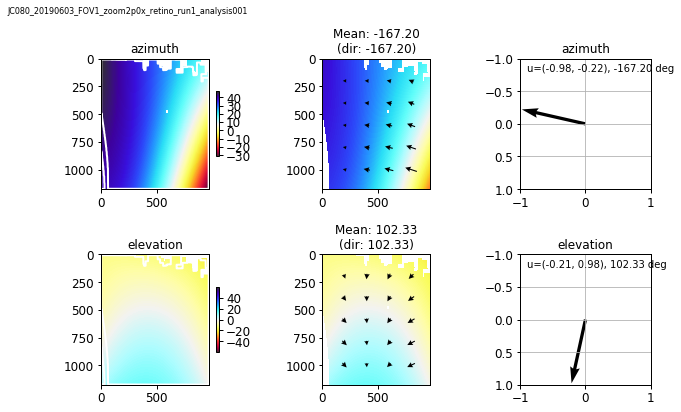

In [96]:
fig, axn = pl.subplots(2,3, figsize=(10,6))

# Maps ------------
ax=axn[0, 0]
im = ax.imshow(img_az,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, shrink=0.5)
ax.set_title('azimuth')
ax = overlay_contours(props, labeled_image, ax=ax, lw=2, lc='w')

ax=axn[1, 0]
im = ax.imshow(img_el,  cmap=cmap_phase, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax, shrink=0.5)
ax.set_title('elevation')
ax = overlay_contours(props, labeled_image, ax=ax, lw=2, lc='w')

# Gradients ------------   
ax=axn[0,1]
ax.imshow(thr_img_az, cmap=cmap_phase, vmin=vmin, vmax=vmax)
grd.plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
ax=axn[1, 1]
ax.imshow(thr_img_el, cmap=cmap_phase, vmin=vmin, vmax=vmax)
grd.plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)

# Unit vectors ------------
ax= axn[0,2]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))
ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1,2]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

# Figure formatting ------------
pl.subplots_adjust(wspace=0.5, hspace=0.5)
label_figure(fig, data_id)

In [1487]:
animalid, session, fov

('JC091', '20190606', 'FOV1_zoom2p0x')

In [1514]:
# class Segmentation():
#     def __init__(self, animalid, session, fov, rootdir='/n/coxfs01/2p-data'
#         self.animalid = animalid
#         self.session = session
#         self.fov = fov
#         self.retino_run = None 
                 
#     def 

# class Struct():
#     pass

In [1515]:
# region_dict={}
# for l in region_labels:
#     n = input("Input region name ID=%i: " % l)
#     if len(n)==0:
#         print("Skipping label %i" % l)
#         continue
#     region_dict.update({l: n})

#region_dict = {1:'Li', 2: '2', 3: '3'}

# Project onto retino dir

In [1417]:
gimg_az = grad_az['image'].copy()
gimg_el = grad_el['image'].copy()

d1, d2 = grad_az['image'].shape
print(d1, d2)
vhat_az = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
vhat_el = grad_el['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
print(vhat_az, vhat_el)


# Projected pixel positoins
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])

# Retino values
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])


(1177, 972)
(array([ 0.99984071, -0.01784793]), array([-0.80545378, -0.59265859]))


#### Test projection cycles

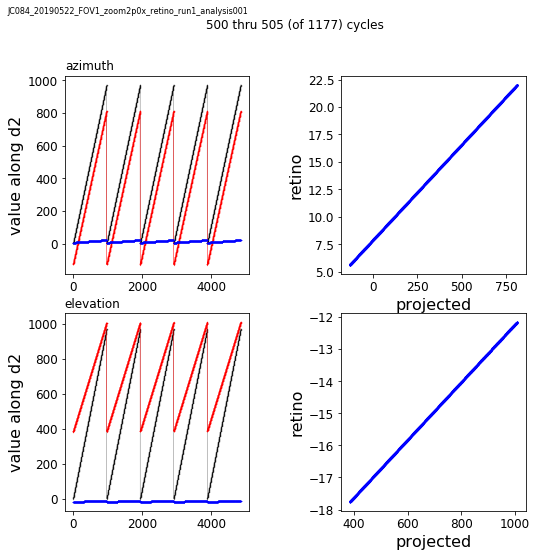

In [219]:
ncyc=5

startcyc=500
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc

fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.set_title('azimuth', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b', marker='.', lw=0, markersize=0.5)
ax.set_ylabel('value along d2')

ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.set_title('elevation', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_el[spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'test_projections__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


# Fit

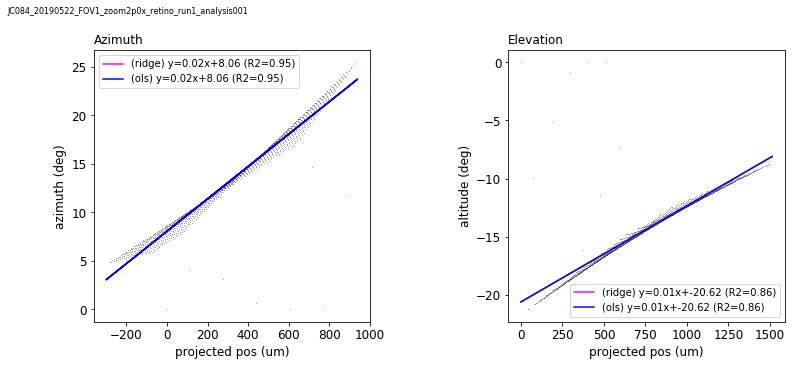

In [220]:
regr_model = 'ridge'
regr_line_color = 'magenta'
regr_model2 = 'ols' 

fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

fitv_az2, regr_az2 = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model2)
fitv_el2, regr_el2 = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model2)

fig, axn = pl.subplots(1,2, figsize=(12, 5))
spacing=800
ax=axn[0]
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)
r2_az = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_az.coef_), float(regr_az.intercept_), r2_az) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az, color=regr_line_color, label=linfit_str)

r2_az2 = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_az2.coef_), float(regr_az2.intercept_), r2_az2) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Azimuth', loc='left')
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
#sns.regplot(proj_el, ret_el, ax=ax, scatter=False, color='k')
ax.scatter(proj_el[0::spacing], ret_el[0::spacing], marker='.', lw=0, color='k', s=1)
r2_el = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_el.coef_), float(regr_el.intercept_), r2_el) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el, color=regr_line_color, label=linfit_str)

r2_el2 = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_el2.coef_), float(regr_el2.intercept_), r2_el2) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Elevation', loc='left')
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'Proj_versus_Retinopos__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s_test' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Compare RF position info

In [221]:
glob.glob(os.path.join(aggregate_dir, 'receptive-fields', 
                                     '%s__%s' % (traceid, rf_fit_desc), 'fits_and_coords*'))

['/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_rfs10.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_r_df.pkl']

In [222]:
rf_fit_desc = 'fit-2dgaus_dff-no-cutoff'
rfpos_fpath = glob.glob(os.path.join(aggregate_dir, 'receptive-fields', 
                                     '%s__%s' % (traceid, rf_fit_desc), 'fits_and_coords*'))[1]
print(rfpos_fpath)

with open(rfpos_fpath, 'rb') as f:
    rfpos = pkl.load(f)
    rfpos=rfpos['df']
rfpos.keys()



/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl


Index([u'r2', u'fwhm_x', u'fwhm_y', u'theta', u'x0', u'y0', u'animalid',
       u'cell', u'datakey', u'experiment', u'fovnum', u'session',
       u'visual_area', u'std_x', u'std_y', u'fwhm_avg', u'std_avg', u'area',
       u'datakey_ix', u'fov_xpos', u'fov_xpos_pix', u'fov_ypos',
       u'fov_ypos_pix', u'ml_pos', u'ap_pos'],
      dtype='object')

In [223]:
fovnum=1
datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
curr_rfs = rfpos[rfpos['datakey']==datakey].copy()
print(datakey, curr_rfs.shape)



('20190522_JC084_fov1', (130, 25))


In [224]:
curr_rfs.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,fwhm_avg,std_avg,area,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
1546,0.767913,24.021635,16.906345,0.057323,24.876325,-10.753185,JC084,0,20190522_JC084_fov1,rfs,...,20.463990,8.708081,231.028964,5,345.675,150,19.0372,10,953.763,831.925
1547,0.561637,36.760755,19.990691,6.066365,27.627541,-9.198699,JC084,1,20190522_JC084_fov1,rfs,...,28.375723,12.074776,418.048225,5,207.405,90,79.9562,42,892.844,970.195
1548,0.585081,27.889204,21.404847,6.220339,17.433089,-11.532854,JC084,5,20190522_JC084_fov1,rfs,...,24.647026,10.488096,339.595870,5,202.796,88,196.083,103,776.717,974.804
1549,0.852636,24.879592,20.229131,0.103731,23.867409,-11.367222,JC084,9,20190522_JC084_fov1,rfs,...,22.554361,9.597600,286.308747,5,400.983,174,173.238,91,799.562,776.617
1550,0.526608,17.091075,23.108701,1.607293,24.144343,-11.700484,JC084,10,20190522_JC084_fov1,rfs,...,20.099888,8.553144,224.677234,5,394.07,171,194.179,102,778.621,783.53


In [225]:
rfdf = curr_rfs.copy()
rfdf['ml_proj']=''
rfdf['ap_proj']=''


In [226]:
#retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
#p_df = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
#fpath = p_df['fpath'].unique()[0]
#gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % magthr_str)
#with open(gpath, 'rb') as f:
#    gresults = pkl.load(f)

# Project FOV coordinates
rfdf['ml_proj'][rfdf.index] = np.array([np.dot(np.array((ml, ap)), vhat_az) \
                                      for ap, ml in curr_rfs[['ap_pos', 'ml_pos']].values])
rfdf['ap_proj'][rfdf.index] = np.array([np.dot(np.array((ml, ap)), vhat_el) \
                                      for ap, ml in curr_rfs[['ap_pos', 'ml_pos']].values])

In [227]:
rfdf.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,area,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,ml_proj,ap_proj
1546,0.767913,24.021635,16.906345,0.057323,24.876325,-10.753185,JC084,0,20190522_JC084_fov1,rfs,...,231.028964,5,345.675,150,19.0372,10,953.763,831.925,710.593875,1250.128100
1547,0.561637,36.760755,19.990691,6.066365,27.627541,-9.198699,JC084,1,20190522_JC084_fov1,rfs,...,418.048225,5,207.405,90,79.9562,42,892.844,970.195,616.486619,1317.049825
1548,0.585081,27.889204,21.404847,6.220339,17.433089,-11.532854,JC084,5,20190522_JC084_fov1,rfs,...,339.595870,5,202.796,88,196.083,103,776.717,974.804,503.011494,1246.043343
1549,0.852636,24.879592,20.229131,0.103731,23.867409,-11.367222,JC084,9,20190522_JC084_fov1,rfs,...,286.308747,5,400.983,174,173.238,91,799.562,776.617,575.549490,1108.737885
1550,0.526608,17.091075,23.108701,1.607293,24.144343,-11.700484,JC084,10,20190522_JC084_fov1,rfs,...,224.677234,5,394.07,171,194.179,102,778.621,783.53,553.538578,1100.597380


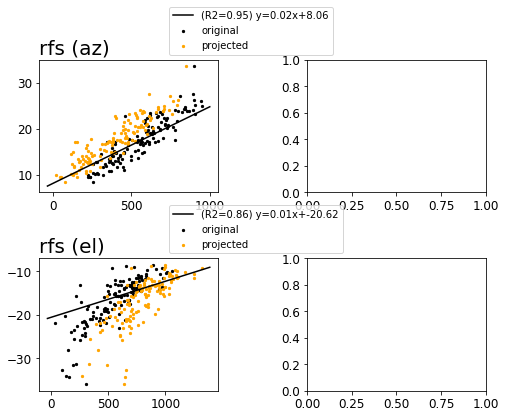

In [228]:
r2_thr=0.5
#rfname = 'rfs10'

fig, axn = pl.subplots(2,2, figsize=(8,8))
for ri, (rfname, expdf) in enumerate(rfdf.groupby(['experiment'])):
    for ci, cond in enumerate(['az', 'el']):
        ax = axn[ci, ri]
        xname = 'ml' if cond=='az' else 'ap'
        yname = 'x0' if cond=='az' else 'y0'

        # Plot RF positions vs. cell locs
        cell_locs = expdf['%s_pos' % xname].values
        rf_locs = expdf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='original')

        proj_locs = expdf['%s_proj' % xname].values
        ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='orange', label='projected')

        #proj_locs2 = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
        #                         for ap, ml in edf[['ap_pos', 'ml_pos']].values]))

        # plot gradient line
        ret_ = ret_az if cond=='az' else ret_el
        fitv_ = fitv_az if cond=='az' else fitv_el
        regr_ = regr_az if cond=='az' else regr_el 
        slope = float(regr_.coef_)
        intercept = float(regr_.intercept_)
        r2_val = skmetrics.r2_score(ret_[~np.isnan(ret_)], fitv_)
        linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, slope, intercept, r2_val) 

        ls = ':' if r2_val < r2_thr else '-'
        label_prefix = 'R2=%.2f' % r2_val
        label = True
        ax = abline(slope, intercept, ax=ax, color='k',
                    label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title('%s (%s)' % (rfname, cond), loc='left', fontsize=20)

        ax.legend(bbox_to_anchor=(0.7, 1), loc='top')

pl.subplots_adjust(top=0.7, wspace=0.5, hspace=0.5)

# Jacobian for magnification

In [285]:
vmin, vmax

(-59.7782, 59.7782)

In [65]:
from skimage.measure import block_reduce

In [66]:
ch_num = 1
fov_imgs = glob.glob(os.path.join(run_dir, 'processed', 'processed*', 
                                    'mcorrected_*mean_deinterleaved',\
                                    'Channel%02d' % ch_num, 'File*', '*.tif')) 
imlist = []
for anat in fov_imgs:
    im = tf.imread(anat)
    imlist.append(im)
surface_img = np.array(imlist).mean(axis=0)

if surface_img.shape[0] != absolute_az.shape[0]:
    reduce_factor = surface_img.shape[0] / absolute_az.shape[0]
    surface_img = block_reduce(surface_img, (2,2), func=np.mean)
        
print(surface_img.shape)

surface_transf = coreg.orient_2p_to_macro(surface_img, zoom_factor=1., 
                                    save=False, normalize=True)
surface_r = coreg.scale_2p_fov(surface_transf, pixel_size=pixel_size)
print(surface_r.shape)



(256, 256)
(1177, 972)


<a list of 5 text.Text objects>

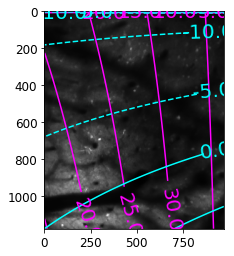

In [341]:
deg_spacing = 5.
lw=1
az_color='magenta'
el_color='cyan'
fontsize=20

imsize = img_az.shape
imgX, imgY = np.meshgrid(range(imsize[0]), range(imsize[1]))

fig, ax = pl.subplots()
levels1 = range(int(np.floor(vmin / deg_spacing) * deg_spacing), 
                int((np.ceil(vmax / deg_spacing) + 1) * deg_spacing), int(deg_spacing))
ax.imshow(surface_r, cmap='gray')
#ax.imshow(img_az, cmap='gray', vmin=vmin, vmax=vmax)
im1 = ax.contour(imgY, imgX, img_az.T, levels1, colors=az_color, linewidth=lw)
s=levels1.index(im1.vmin)
e=levels1.index(im1.vmax)
pl.clabel(im1, levels1[s:e], fontsize=fontsize, inline=5, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)

im2 = ax.contour(imgY, imgX, img_el.T, levels1, colors=el_color, linewidth=lw)
s=levels1.index(im2.vmin)
e=levels1.index(im2.vmax)
pl.clabel(im2, levels1[s:e], fontsize=fontsize, inline=3, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)




In [333]:
img_el.T.min()

-11.748874361948758

In [371]:
dets = np.array([np.linalg.det([[Hx, Hy], [Vx, Vy]]) for (Hx, Hy, Vx, Vy) \
        in zip(grad_az['gradient_x'].ravel(), grad_az['gradient_y'].ravel(),
               grad_el['gradient_x'].ravel(), grad_el['gradient_y'].ravel())])

# dets = np.array([np.linalg.det([[Hx, Hy], [Vx, Vy]]) for (Hx, Hy, Vx, Vy) \
#         in zip(grad_az['gradient_y'].ravel(), grad_az['gradient_x'].ravel(),
#                grad_el['gradient_y'].ravel(), grad_el['gradient_x'].ravel())])
    


In [384]:
d1, d2 = grad_az['gradient_x'].shape
detr = np.reshape(dets, (d1, d2))

detr=1./detr

In [389]:
detr_mask = np.ma.array(detr, mask=np.isinf(detr))


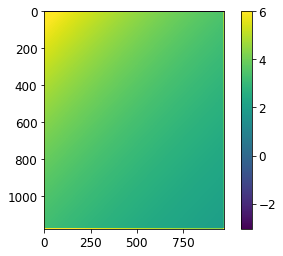

In [408]:
fig, ax = pl.subplots()
ax.imshow(detr_mask/1000., vmax=6) #=5.) #, vmin=0.005)
pl.colorbar(im, ax=ax)

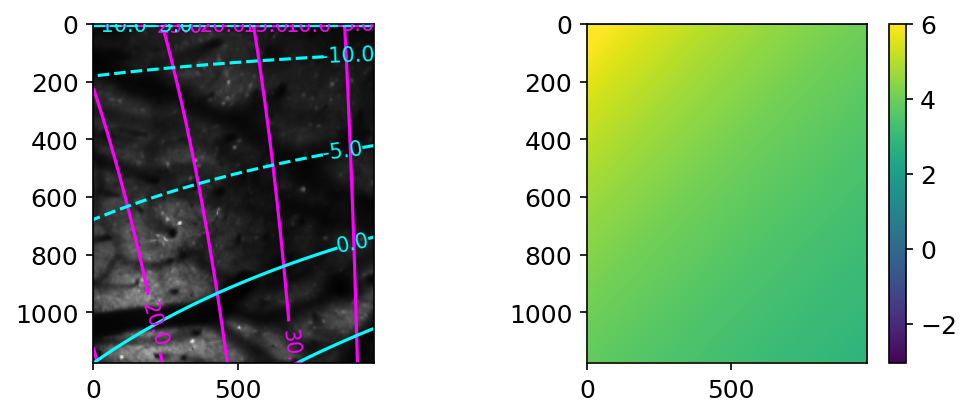

In [413]:
deg_spacing = 5.
lw=1
az_color='magenta'
el_color='cyan'
fontsize=10

imsize = img_az.shape
imgX, imgY = np.meshgrid(range(imsize[0]), range(imsize[1]))

fig, axn = pl.subplots(1, 2, figsize=(8,3), dpi=dpi)
levels1 = range(int(np.floor(vmin / deg_spacing) * deg_spacing), 
                int((np.ceil(vmax / deg_spacing) + 1) * deg_spacing), int(deg_spacing))

ax=axn[0]
ax.imshow(surface_r, cmap='gray')
#ax.imshow(img_az, cmap='gray', vmin=vmin, vmax=vmax)
im1 = ax.contour(imgY, imgX, img_az.T, levels1, colors=az_color, linewidth=lw)
s=levels1.index(im1.vmin)
e=levels1.index(im1.vmax)
pl.clabel(im1, levels1[s:e], fontsize=fontsize, inline=5, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)

im2 = ax.contour(imgY, imgX, img_el.T, levels1, colors=el_color, linewidth=lw)
s=levels1.index(im2.vmin)
e=levels1.index(im2.vmax)
pl.clabel(im2, levels1[s:e], fontsize=fontsize, inline=3, fmt='%1.1f') #, inline_spacing=2, manual=label_pos)

ax=axn[1]
im=ax.imshow(detr_mask/1000., vmax=6) #=5.) #, vmin=0.005)
pl.colorbar(im, ax=ax)


# Get mask info

In [16]:
# Get ROIID and projection image
masks_soma, masks_np, zimg = ret_utils.load_soma_and_np_masks(RETID)
roiid = RETID['PARAMS']['roi_id']
ds_factor = int(RETID['PARAMS']['downsample_factor'])
nrois_total, d1, d2 = masks_soma.shape

# fig, ax = pl.subplots()
# roi_utils.plot_neuropil_masks(masks_soma, masks_np, zimg, ax=ax)
# ax.set_title('soma + neuropil masks')
# label_figure(fig, data_id)
# pl.savefig(os.path.join(curr_dst_dir, 'soma-v-neuropil-masks.png'))

... FOV size: (256, 256) (downsample factor=2)


# Dilate soma masks
From Liang et al., 2018, Cell.
1. Assign center of neuropil ring w/ preferred retino location.
2. From Neurpil ring center, dilate by a disk of 10um radius (20um diam)
3. Average overlapping disks
4. Spatially smooth w/ isotropic 2D Guassian filter (std=2um) for final pixe-wise estimates 

Nots: measured pixel size: (2.3, 1.9)
Want to dilate by ~9.52380952381


In [403]:
desired_radius_um = 10.0 #20.0
pixel_size = putils.get_pixel_size()
um_per_pixel = np.mean(pixel_size) / ds_factor # divide by DS factor (pixels are half if ds=2)
pixels2dilate = desired_radius_um/um_per_pixel
print("Measured pixel size: %s (~%.2fum/pix).\nPixel size with ds_factor %.2f = %i" % (str(pixel_size), um_per_pixel, ds_factor, pixels2dilate))



Measured pixel size: (2.3, 1.9) (~1.05um/pix).
Pixel size with ds_factor 2.00 = 9


In [404]:
check_masks = False

# Set kernel params
kernel_size = np.ceil(pixels2dilate) #+2 #21
kernel_radius = (kernel_size - 1) // 2
x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

# Create three kernels for the sake of example
radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)
kernel_diam_um = (kernel.shape[0]*um_per_pixel)
print("Kernel (%s), Dilation diameter (um): %.2f" % (str(kernel.shape), kernel_diam_um))

## Dilate all masks with kernel
dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

if check_masks:
    fig, axn = pl.subplots(1, 2, figsize=(3,6))
    axn[0].imshow(kernel)

    rid = 33
    axn[1].imshow(dilated_masks[rid, :, :])
    axn[1].set_title("Kernel size: %.2f\n(final diam: %.2f um)" % (kernel_size, kernel_diam_um))
    x, y = np.where(dilated_masks[rid, :, :]>0)
    print "X/Y-min/max:", x.max()-x.min(), y.max()-y.min()


Kernel ((9, 9)), Dilation diameter (um): 9.45


# Rescale FOV image

((256, 256), (1177, 972))


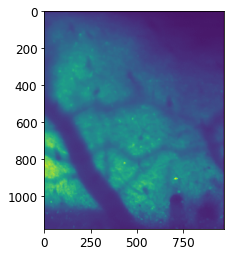

In [405]:
pixel_size = putils.get_pixel_size()
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)

zimg_r = coreg.transform_2p_fov(zimg, pixel_size)
print(zimg.shape, zimg_r.shape)

pl.figure()
pl.imshow(zimg_r)

# Process raw traces

In [406]:
#### Load raw and process traces -- returns average trace for condition
temporal_ds = float(RETID['PARAMS']['average_frames'])

#### Load raw and process traces -- returns average trace for condition
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
temporal_ds = float(RETID['PARAMS']['average_frames'])
np_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='neuropil')
soma_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='raw')

... loading traces (neuropil)
... loading traces (raw)


# Do FFT analysis

Mag ratio: 0.01
[soma] 91 out of 311 cells pass mag-ratio thr (thr>=0.010, either)
[np] 75 out of 311 cells pass mag-ratio thr (thr>=0.100, either)


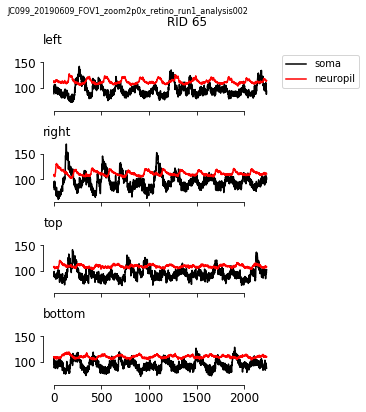

In [409]:
mag_thr=0.01 #if trace_type == 'neuropil' else 0.02
np_mag_thr = 0.1
pass_criterion='either'
plot_examples = True


print("Mag ratio: %.2f" % mag_thr)

#### Get FFT params
n_frames = scaninfo['stimulus']['n_frames']
frame_rate = scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate)) # Label frequency bins
sorted_freq_idxs = np.argsort(freqs)

#### Do FFT
fft_soma = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in soma_traces.items())
fft_np = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in np_traces.items())

# Get magratios -- each column is a condition
magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
magratios_np = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_np.items()))

# Get phases
phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))
phases_np = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_np.items()))

# Get average across conditions
mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]

# Filter out bad cells
conds = [c for c in magratios_soma.columns if c!='blank']
if pass_criterion=='all':
    soma_rois = [i for i in magratios_soma.index if all(magratios_soma[conds].loc[i] >= mag_thr)]
    np_rois = [i for i in magratios_np.index if all(magratios_np[conds].loc[i] >= np_mag_thr)]
elif pass_criterion=='either':
    az_conds = [c for c in magratios_soma.columns if c in ['right', 'left']]
    el_conds = [c for c in magratios_soma.columns if c in ['top', 'bottom']]
    soma_rois = [i for i in magratios_soma.index \
                if (any(magratios_soma[az_conds].loc[i] >= mag_thr) \
                    and (any(magratios_soma[el_conds].loc[i] >= mag_thr))) ]
    np_rois = [i for i in magratios_np.index \
                if (any(magratios_np[az_conds].loc[i] >= mag_thr) \
                    and (any(magratios_np[el_conds].loc[i] >= np_mag_thr))) ]
elif pass_criterion == 'any':
    soma_rois = [i for i in magratios_soma.index if any(magratios_soma[conds].loc[i] >= mag_thr) ]
    np_rois = [i for i in magratios_np.index if any(magratios_np[conds].loc[i] >= np_mag_thr)]
else:
    soma_rois = magratios_soma.index.tolist()
    np_rois = magratios_np.index.tolist()

nrois_total = len(mean_magratio_values_soma)
print("[soma] %i out of %i cells pass mag-ratio thr (thr>=%.3f, %s)" % (len(soma_rois), nrois_total, mag_thr, pass_criterion))
print("[np] %i out of %i cells pass mag-ratio thr (thr>=%.3f, %s)" % (len(np_rois), nrois_total, np_mag_thr, pass_criterion))

sorted_by_mag = [r for r in sorted_rois_soma if r in roi_list]

# Look at example cell
if plot_examples:
    ret_utils.plot_some_example_traces(soma_traces, np_traces, plot_rois=sorted_rois_soma[0:3],
                         dst_dir=curr_dst_dir, data_id=data_id)
    

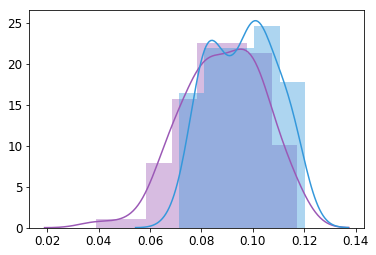

In [410]:
pl.figure()
sns.distplot(magratios_np.loc[soma_rois].mean(axis=1))
sns.distplot(magratios_np.loc[np_rois].mean(axis=1))

# Assign phase to neuropil

In [411]:
azim_phase_np, elev_phase_np, azim_np, elev_np = get_phase_masks(dilated_masks, phases_np, 
                                                            average_overlap=average_overlap, 
                                                            roi_list=None, use_cont=use_cont,
                                                            mask_thr=mask_thr, return_absolute=True)


In [412]:
# soma_mag_means = magratios_soma.mean(axis=1)
np_mag_means_from_soma = magratios_np.loc[soma_rois].mean(axis=1)
np_mag_means_from_np = magratios_np.loc[np_rois].mean(axis=1)

np_mag_means = magratios_np.mean(axis=1) # magratios_np.loc[np_rois].mean(axis=1)

In [413]:
np_mag_thr=0.1
pass_np_rlist_from_soma = np_mag_means_from_soma[np_mag_means_from_soma>=np_mag_thr].index.tolist()
pass_np_rlist_from_np = np_mag_means_from_np[np_mag_means_from_np>=np_mag_thr].index.tolist()
pass_np_rlist = np_mag_means[np_mag_means>=np_mag_thr].index.tolist()

print("NP filtered: %i, Soma filtered: %i, NP mean: %i" 
      % (len(pass_np_rlist_from_np), len(pass_np_rlist_from_soma), len(pass_np_rlist)))
fail_np_rlist_from_soma = [r for r in roi_list if r not in pass_np_rlist_from_soma]
fail_np_rlist = [r for r in roi_list if r not in pass_np_rlist]

NP filtered: 33, Soma filtered: 24, NP mean: 51


In [415]:
animalid, session

('JC099', '20190609')

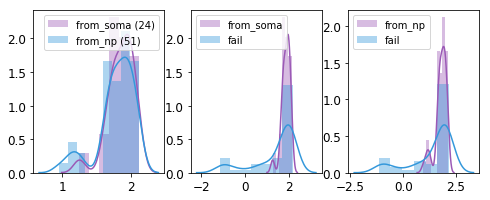

In [416]:
fig, axn = pl.subplots(1,3, figsize=(8,3))
ax = axn[0]
sns.distplot(azim_np[pass_np_rlist_from_soma].values, label='from_soma (%i)' % len(pass_np_rlist_from_soma), ax=ax)
sns.distplot(azim_np[pass_np_rlist].values, label='from_np (%i)' % len(pass_np_rlist), ax=ax)
ax.legend()

ax = axn[1]
sns.distplot(azim_np[pass_np_rlist_from_soma].values, label='from_soma', ax=ax)
sns.distplot(azim_np[fail_np_rlist_from_soma].values, label='fail', ax=ax)
ax.legend()


ax = axn[2]
sns.distplot(azim_np[pass_np_rlist].values, label='from_np', ax=ax)
sns.distplot(azim_np[fail_np_rlist].values, label='fail', ax=ax)
ax.legend()


In [417]:
import copy

In [418]:
print(len(pass_np_rlist))

51


In [420]:
roi_list = copy.copy(pass_np_rlist)
print(len(roi_list))

51


In [421]:
use_cont = True
average_overlap = True
filter_by_mag = True
mask_thr=0.01

# Set bounds for averaging
vmin = -np.pi if use_cont else 0
vmax = np.pi if use_cont else 2*np.pi

# Assign phase value to dilated masks
azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, phases_np, average_overlap=average_overlap, 
                                               roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

azim_phase_soma, elev_phase_soma = get_phase_masks(masks_soma, phases_soma, average_overlap=average_overlap, 
                                                   roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

# Mask images for plotting
azim_phase_mask_np = np.ma.masked_where(azim_phase_np==-100, azim_phase_np)
elev_phase_mask_np = np.ma.masked_where(elev_phase_np==-100, elev_phase_np)

azim_phase_mask_soma = np.ma.masked_where(azim_phase_soma==-100, azim_phase_soma)
elev_phase_mask_soma = np.ma.masked_where(elev_phase_soma==-100, elev_phase_soma)


# Smooth

In [422]:
# Spatial smooth neuropil dilated masks 
smooth_fwhm = 7 #21
azim_smoothed = ret_utils.smooth_neuropil(azim_phase_np, smooth_fwhm=smooth_fwhm)
elev_smoothed = ret_utils.smooth_neuropil(elev_phase_np, smooth_fwhm=smooth_fwhm)

if 'zoom1p0x' in fov:
    print("... resizing")
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
    
azim_smoothed = fill_and_smooth_nans(azim_smoothed)
elev_smoothed = fill_and_smooth_nans(elev_smoothed)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_smoothed, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_smoothed, pixel_size, normalize=False)
print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())

az_fill = azim_r.copy()
el_fill = elev_r.copy()

azim_soma_r = coreg.transform_2p_fov(azim_phase_mask_np, pixel_size, normalize=False)
elev_soma_r = coreg.transform_2p_fov(elev_phase_mask_soma, pixel_size, normalize=False)

(0.0, 2.3776783896661216)


(u'/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_733e38/retino-structure', 'soma-v-neuropil_dilate-center-10_spatial-smooth-7_circ_magthr-0.010-either')


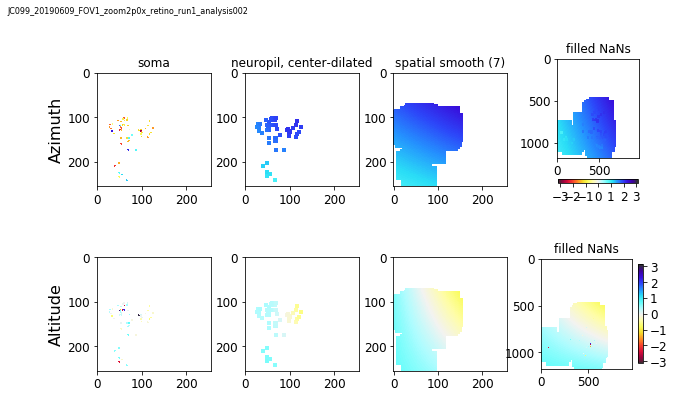

In [423]:
fig, axn = pl.subplots(2,4, figsize=(10,6))

ax = axn[0,0]
ax.imshow(azim_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('soma')
ax.set_ylabel('Azimuth')

ax = axn[0, 1]
ax.set_title('neuropil, center-dilated')
ax.imshow(azim_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[0, 2]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 3]
im0 = ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)
ax.imshow(azim_soma_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 0]
ax.imshow(elev_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 3]
im1= ax.imshow(el_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im1, ax=ax, orientation='vertical', shrink=0.7)
ax.imshow(elev_soma_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

pl.subplots_adjust(wspace=0.3, hspace=0.3)
putils.label_figure(fig, data_id)

figname = 'soma-v-neuropil_dilate-center-%i_spatial-smooth-%i_circ_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

#### Plot smoothed azimuth neuropil

Text(0.5,1,u'Altitude')

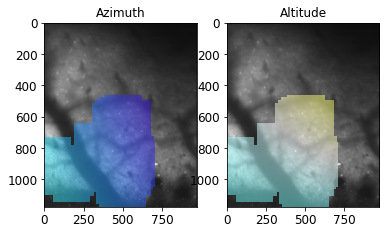

In [424]:
cmap = 'nipy_spectral' # cmap_phase
overlay = True
overlay_str = '_overlay' if overlay else ''
alpha = 0.5 if overlay else 1.0

fig, axn = pl.subplots(1,2)
ax = axn[0]
if overlay:
    ax.imshow(zimg_r, cmap='gray')
ax.imshow(azim_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
ax.set_title('Azimuth')

ax = axn[1]
if overlay:
    ax.imshow(zimg_r, cmap='gray')
ax.imshow(elev_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
ax.set_title('Altitude')

#figname = 'overlay_dilate-%i_spatial-fwhm-%i%s' % (kernel_size, smooth_fwhm, overlay_str)

#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


# Calculate image gradient

In [425]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [426]:
plot_degrees = True

vmin=-np.pi
vmax=np.pi
img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)


# Calculate gradients
if plot_degrees:
    grad_az = calculate_gradients(img_az)
    grad_el = calculate_gradients(img_el)
    vmin, vmax = (screen_min, screen_max)
else:
    grad_az = calculate_gradients(az_fill)
    grad_el = calculate_gradients(el_fill)
    # vmin, vmax = (-np.pi, np.pi)
    
print(vmin, vmax)

(u'/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_733e38/retino-structure', 'gradients_dilate-center-10_spatial-smooth-7_degrees_circ_magthr-0.010-either')


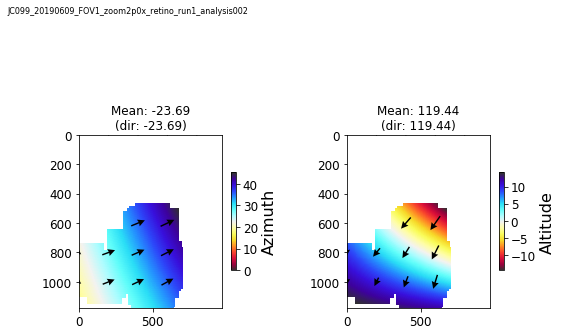

In [429]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''
fig, axn = pl.subplots(1, 2, figsize=(8,6))
ax = axn[0]
im = ax.imshow(img_az, cmap=cmap_phase)#, vmin=vmin, vmax=vmax)
plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Azimuth')

ax = axn[1]
im = ax.imshow(img_el,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Altitude')

pl.subplots_adjust(wspace=0.5, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'gradients_dilate-center-%i_spatial-smooth-%i_%s_circ_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)

#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [382]:
len(roi_list)

48

## Compute unit vector and project

In [383]:
avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL]avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ]avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

print(vhat_az, vhat_el)


[EL]avg dir: 30.18 deg
[AZ]avg dir: 179.47 deg
(array([-0.99995744,  0.00922633]), array([ 0.8644171 ,  0.50277538]))


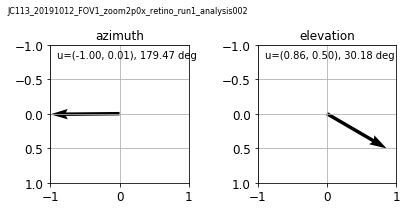

In [384]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))

ax = axn[0]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))

ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'gradients_unitvec_dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


# Project coordinates onto "prevailing" retino dir

In [385]:
gimg_az = grad_az['image'].copy()
gimg_el = grad_el['image'].copy()

d1, d2 = grad_az['image'].shape
print(d1, d2)
vhat_az = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
vhat_el = grad_el['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
print(vhat_az, vhat_el)


# Projected pixel positoins
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])

# Retino values
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])


(1177, 972)
(array([-0.99995744,  0.00922633]), array([ 0.8644171 ,  0.50277538]))


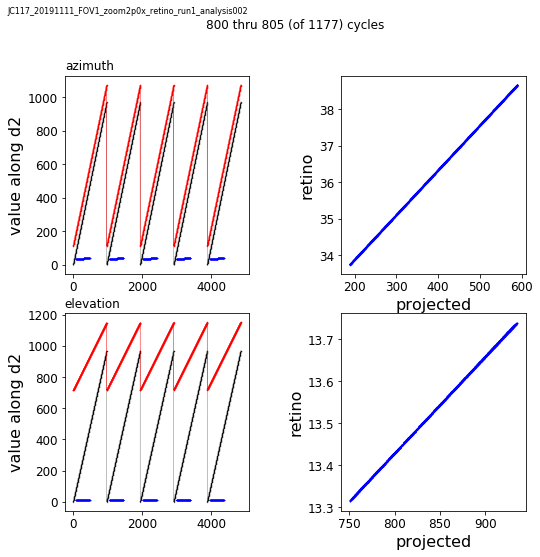

In [358]:
fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()

ncyc=5

startcyc=800
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.set_title('azimuth', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b', marker='.', lw=0, markersize=0.5)
ax.set_ylabel('value along d2')

ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.set_title('elevation', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_el[spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'test_projections__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


## Fit linear

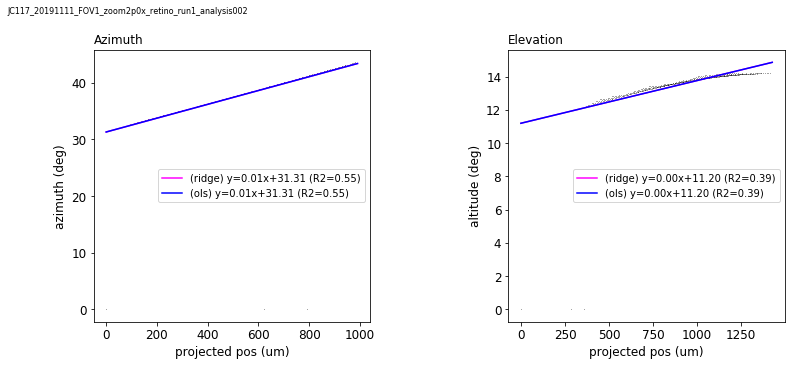

In [359]:
regr_model = 'ridge'
regr_line_color = 'magenta'
regr_model2 = 'ols' 

fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

fitv_az2, regr_az2 = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model2)
fitv_el2, regr_el2 = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model2)

fig, axn = pl.subplots(1,2, figsize=(12, 5))
spacing=800
ax=axn[0]
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)
r2_az = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_az.coef_), float(regr_az.intercept_), r2_az) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az, color=regr_line_color, label=linfit_str)

r2_az2 = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_az2.coef_), float(regr_az2.intercept_), r2_az2) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Azimuth', loc='left')
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
#sns.regplot(proj_el, ret_el, ax=ax, scatter=False, color='k')
ax.scatter(proj_el[0::spacing], ret_el[0::spacing], marker='.', lw=0, color='k', s=1)
r2_el = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_el.coef_), float(regr_el.intercept_), r2_el) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el, color=regr_line_color, label=linfit_str)

r2_el2 = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_el2.coef_), float(regr_el2.intercept_), r2_el2) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Elevation', loc='left')
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'Proj_versus_Retinopos__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s_test' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Example FOV -------------------------------------------------------------------------------

In [191]:
animalid = 'JC084' #'JC085'
session = '20190522' #'20190626'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run1'


# Load data

In [194]:
# Load data metainfo
# run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
# RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
# analysis_dir = RETID['DST']
# retinoid = RETID['analysis_id']
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) 
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
curr_dst_dir = os.path.join(run_dir, 'retino_analsysis', 'retino-structure')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print("Saving output to:\n %s" % curr_dst_dir)

FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC084_20190522_FOV1_zoom2p0x_retino_run1_analysis001
Saving output to:
 /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analsysis/retino-structure
